# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
import random
from pprint import pprint
from pandas.io.json import json_normalize

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"
file_df = pd.read_csv(output_data_file)

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

file_df.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,0,ostrovnoy,2,RU,1558378754,72,68.05,39.51,37.50,7.16
1,1,mahebourg,75,MU,1558378503,74,-20.41,57.70,78.80,11.41
2,2,qaanaaq,25,GL,1558378755,73,77.48,-69.36,22.20,2.37
3,3,zhuhai,0,CN,1558378755,39,40.71,112.04,44.60,4.47
4,4,cape town,20,ZA,1558378755,76,-33.93,18.42,55.99,8.05


## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)
# print(cities)

627

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Performing a series of successive API calls and storing the data in an empty list

url = "http://api.openweathermap.org/data/2.5/weather?"


city_data = []

for index, city in enumerate(cities):
    query_url = url + "appid=" + weather_api_key + "&q=" + city+  "&units=imperial"
    response = requests.get(query_url).json()
    city_data.append(response)

In [4]:
# Perform a weather check on each city using the data from the new list above 

# Printing the log file as each data is being processed

print("Beginning Data Retrieval")     
print("-----------------------------")

clean_data = []

for index, data in enumerate(city_data):
    try:
        data['name']
        clean_data.append(data)
    except KeyError:
        continue
        
        
print("-----------------------------")
print("Data Retrieval Complete")
print("-----------------------------")

Beginning Data Retrieval
-----------------------------
-----------------------------
Data Retrieval Complete
-----------------------------


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Export the city data into a csv file

city_id = []
city_name = []
cloud_data = []
country = []
date = []
humidity = []
lat_data = []
lon_data = []
temp_data = []
speed_data = []


for index, data in enumerate(clean_data):
    city_id.append(index)
    city_name.append(data['name'])
    cloud_data.append(data['clouds']['all'])
    country.append(data['sys']['country'])
    date.append(data['dt'])
    humidity.append(data['main']['humidity'])
    lat_data.append(data['coord']['lat'])
    lon_data.append(data['coord']['lon'])
    temp_data.append(data['main']['temp_max'])
    speed_data.append(data['wind']['speed'])

# Creating the new city DataFrame 
    
city_df = pd.DataFrame({"City ID": city_id, "City": city_name, "Cloudiness": cloud_data, "Country": country,
                       "Date": date, "Humidity": humidity, "Latitude": lat_data, "Longitude": lon_data,
                       "Max Temp": temp_data, "Wind Speed": speed_data})

# Exporting the city DataFrame into a csv file

city_date_file = city_df.to_csv("../output_data/city_df.csv", index=False)


In [6]:
# Displaying the DataFrame

new_file = pd.read_csv("../output_data/city_df.csv")

del new_file['City ID']

new_file.head()

,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed
0,Rikitea,100,PF,1594694160,84,-23.12,-134.97,72.70,15.21
1,Oranjemund,8,NaN,1594694752,76,-28.55,16.43,53.01,7.72
2,Clyde River,1,CA,1594694100,81,70.47,-68.59,46.40,5.82
3,Lanigan,70,CA,1594694583,87,51.85,-105.03,55.54,12.39
4,Port Alfred,8,ZA,1594694484,49,-33.59,26.89,54.57,28.70


In [7]:
new_file.dtypes

City           object
Cloudiness      int64
Country        object
Date            int64
Humidity        int64
Latitude      float64
Longitude     float64
Max Temp      float64
Wind Speed    float64
dtype: object

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [8]:
# Converting Humidity data series to float

new_file['Humidity'] = new_file['Humidity'].astype(float)
new_file['Humidity'].dtypes

dtype('float64')

In [9]:
hum_file = new_file.loc[:, ['Humidity']]
hum_file

,Humidity
0,84.0
1,76.0
2,81.0
3,87.0
4,49.0
...,...
565,84.0
566,98.0
567,52.0
568,80.0


In [10]:
# Inspecting the data and searching for the cities where the humidity > 100%

new_file[new_file["Humidity"]> 100]


,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed


In [11]:
# Inspecting the data and removing the cities where the humidity > 100%

# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

clean_city_data = new_file[new_file["Humidity"]<= 100]
clean_city_data.head()


,City,Cloudiness,Country,Date,Humidity,Latitude,Longitude,Max Temp,Wind Speed
0,Rikitea,100,PF,1594694160,84.0,-23.12,-134.97,72.70,15.21
1,Oranjemund,8,NaN,1594694752,76.0,-28.55,16.43,53.01,7.72
2,Clyde River,1,CA,1594694100,81.0,70.47,-68.59,46.40,5.82
3,Lanigan,70,CA,1594694583,87.0,51.85,-105.03,55.54,12.39
4,Port Alfred,8,ZA,1594694484,49.0,-33.59,26.89,54.57,28.70


In [12]:
# Extract relevant fields from the data frame
clean_city = clean_city_data["City"]
clean_lat = clean_city_data["Latitude"]
clean_lng = clean_city_data["Longitude"]
clean_maxtemp = clean_city_data["Max Temp"]
clean_hum = clean_city_data["Humidity"]
clean_cloud = clean_city_data["Cloudiness"]
clean_windspeed = clean_city_data["Wind Speed"]
clean_country = clean_city_data["Country"]
clean_date = clean_city_data["Date"]

# Export the City_Data into a csv
clean_city_data.index.names = ["City ID"]
clean_city_data_file = clean_city_data.to_csv("../output_data/clean_city_data.csv")



## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [13]:
# Create a function for the following scatter plots
def plot(x_values, y_values):    
    plt.figure(figsize=(8,5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.scatter(x_values, y_values, edgecolors="black")
    plt.savefig(savefile)
    plt.show()

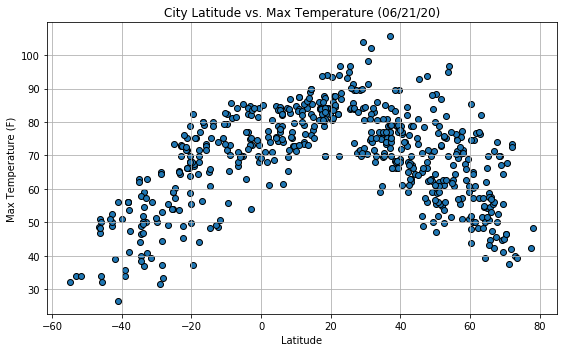

In [14]:
# Latitude vs. Temperature Plot

x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Max Temp"]
xlabel = "Latitude"
ylabel = "Max Temperature (F)"
title = "City Latitude vs. Max Temperature (06/21/20)"
savefile = "../output_data/Latitude vs. Temperature Plot.png"

plot(x_values, y_values)

## Latitude vs. Humidity Plot

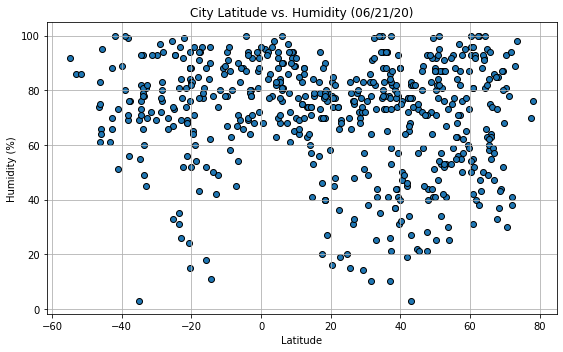

In [15]:
# Latitude vs. Humidity Plot

x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Humidity"]
xlabel = "Latitude"
ylabel = "Humidity (%)"
title = "City Latitude vs. Humidity (06/21/20)"
savefile = "../output_data/Latitude vs. Humidity Plot.png"

plot(x_values, y_values)

## Latitude vs. Cloudiness Plot

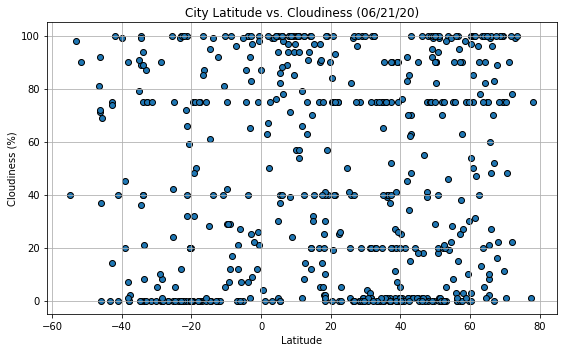

In [16]:
# Latitude vs. Cloudiness Plot

x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Cloudiness"]
xlabel = "Latitude"
ylabel = "Cloudiness (%)"
title = "City Latitude vs. Cloudiness (06/21/20)"
savefile = "../output_data/Latitude vs. Cloudiness Plot.png"

plot(x_values, y_values)

## Latitude vs. Wind Speed Plot

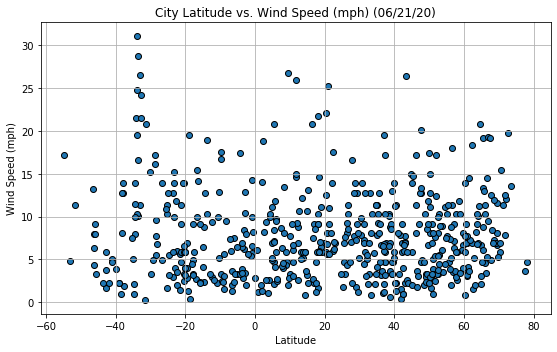

In [17]:
# Latitude vs. Wind Speed Plot

x_values = clean_city_data["Latitude"]
y_values = clean_city_data["Wind Speed"]
xlabel = "Latitude"
ylabel = "Wind Speed (mph)"
title = "City Latitude vs. Wind Speed (mph) (06/21/20)"
savefile = "../output_data/Latitude vs. Wind Speed Plot.png"

plot(x_values, y_values)

## Linear Regression

In [18]:
# OPTIONAL: Create a function to create Linear Regression plots

def plot(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.figure(figsize=(8,5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    print(f'The rvalue is: {round((rvalue), 5)}')
    print(f'The r-squared is: {round((rvalue**2), 5)}')
    plt.annotate(line_eq, (0,35), color="red", fontsize=15)
    plt.savefig(savefile)
    plt.show()   

In [19]:
# Create Northern and Southern Hemisphere DataFrames
northhem_data = new_file[new_file["Latitude"]> 0]
southhem_data = new_file[new_file["Latitude"]<=0]


####  Northern Hemisphere - Latitude vs. Max Temperature Linear Regression

The rvalue is: -0.62747
The r-squared is: 0.39372


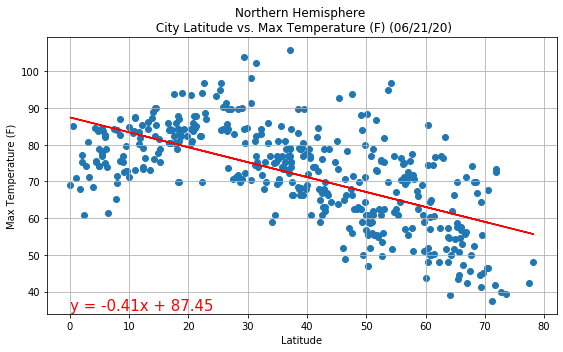

In [20]:
# Northern Hemisphere - Latitude vs. Max Temperature Linear Regression

x_values = northhem_data["Latitude"]
y_values = northhem_data["Max Temp"]
xlabel = "Latitude"
ylabel = "Max Temperature (F)"
title = "Northern Hemisphere \n City Latitude vs. Max Temperature (F) (06/21/20)"
savefile = "../output_data/Northern Hemisphere - Latitude vs. Max Temperature Linear Regression.png"

plot(x_values, y_values)

####  Southern Hemisphere - Latitude vs. Max Temperature Linear Regression

The rvalue is: 0.75384
The r-squared is: 0.56827


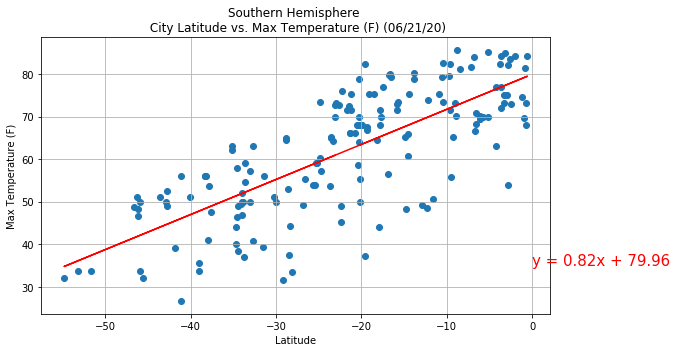

In [21]:
# Southern Hemisphere - Latitude vs. Max Temperature Linear Regression

x_values = southhem_data["Latitude"]
y_values = southhem_data["Max Temp"]
xlabel = "Latitude"
ylabel = "Max Temperature (F)"
title = "Southern Hemisphere \n City Latitude vs. Max Temperature (F) (06/21/20)"
savefile = "../output_data/Southern Hemisphere - Latitude vs. Max Temperature Linear Regression.png"

plot(x_values, y_values)

####  Northern Hemisphere - Latitude vs. Humidity Linear Regression

The rvalue is: -0.11519
The r-squared is: 0.01327


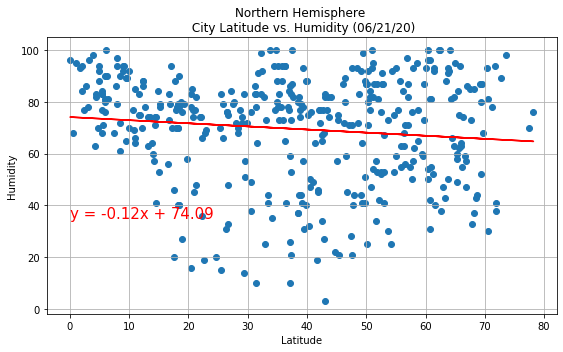

In [22]:
# Northern Hemisphere - Latitude vs. Humidity Linear Regression

x_values = northhem_data["Latitude"]
y_values = northhem_data["Humidity"]
xlabel = "Latitude"
ylabel = "Humidity"
title = "Northern Hemisphere \n City Latitude vs. Humidity (06/21/20)"
savefile = "../output_data/Northern Hemisphere - Latitude vs. Humidity Linear Regression.png"

plot(x_values, y_values)

####  Southern Hemisphere - Latitude vs. Humidity (%)  Linear Regression

The rvalue is: 0.04147
The r-squared is: 0.00172


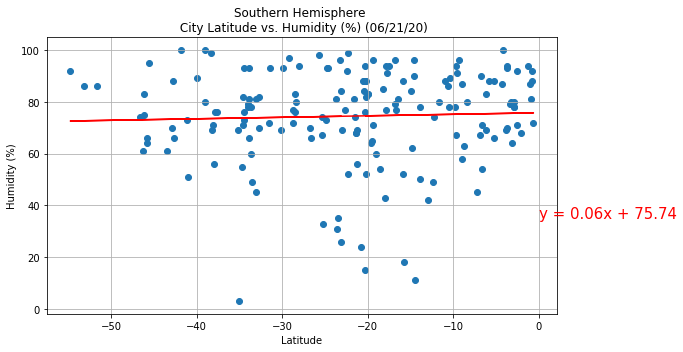

In [23]:
# Southern Hemisphere - Latitude vs. Humidity (%) Linear Regression

x_values = southhem_data["Latitude"]
y_values = southhem_data["Humidity"]
xlabel = "Latitude"
ylabel = "Humidity (%)"
title = "Southern Hemisphere \n City Latitude vs. Humidity (%) (06/21/20)"
savefile = "../output_data/Southern Hemisphere - Latitude vs. Humidity (%) Linear Regression.png"

plot(x_values, y_values)

####  Northern Hemisphere - Latitude vs. Cloudiness Linear Regression

The rvalue is: -0.03558
The r-squared is: 0.00127


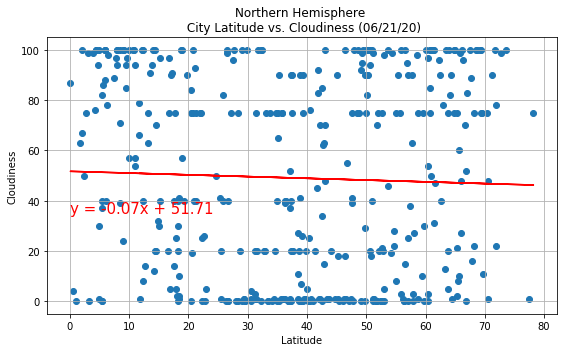

In [24]:
# Northern Hemisphere - Latitude vs. Cloudiness Linear Regression

x_values = northhem_data["Latitude"]
y_values = northhem_data["Cloudiness"]
xlabel = "Latitude"
ylabel = "Cloudiness"
title = "Northern Hemisphere \n City Latitude vs. Cloudiness (06/21/20)"
savefile = "../output_data/Northern Hemisphere - Latitude vs. Cloudiness Linear Regression.png"

plot(x_values, y_values)

####  Southern Hemisphere - Latitude vs. Cloudiness Linear Regression

The rvalue is: -0.02336
The r-squared is: 0.00055


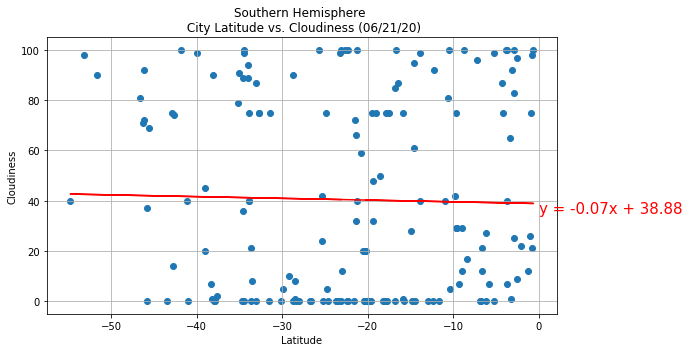

In [25]:
# Southern Hemisphere - Latitude vs. Cloudiness Linear Regression

x_values = southhem_data["Latitude"]
y_values = southhem_data["Cloudiness"]
xlabel = "Latitude"
ylabel = "Cloudiness"
title = "Southern Hemisphere \n City Latitude vs. Cloudiness (06/21/20)"
savefile = "../output_data/Southern Hemisphere - Latitude vs. Cloudiness Linear Regression.png"

plot(x_values, y_values)

####  Northern Hemisphere - Latitude vs. Wind Speed (mph) Linear Regression

The rvalue is: 0.04786
The r-squared is: 0.00229


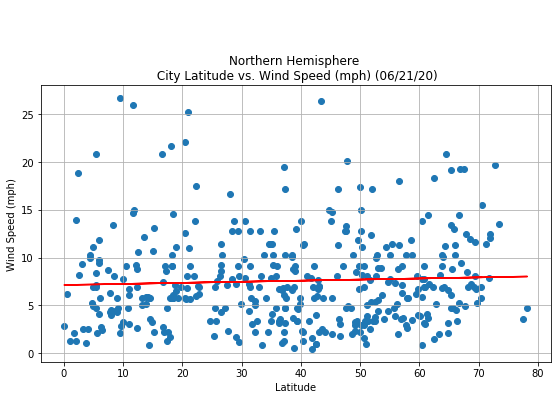

In [26]:
# Northern Hemisphere - Latitude vs. Wind Speed (mph) Linear Regression

x_values = northhem_data["Latitude"]
y_values = northhem_data["Wind Speed"]
xlabel = "Latitude"
ylabel = "Wind Speed (mph)"
title = "Northern Hemisphere \n City Latitude vs. Wind Speed (mph) (06/21/20)"
savefile = "../output_data/Northern Hemisphere - Latitude vs. Wind Speed (mph) Linear Regression.png"

plot(x_values, y_values)

####  Southern Hemisphere - Latitude vs. Wind Speed (mph) Linear Regression

The rvalue is: -0.18452
The r-squared is: 0.03405


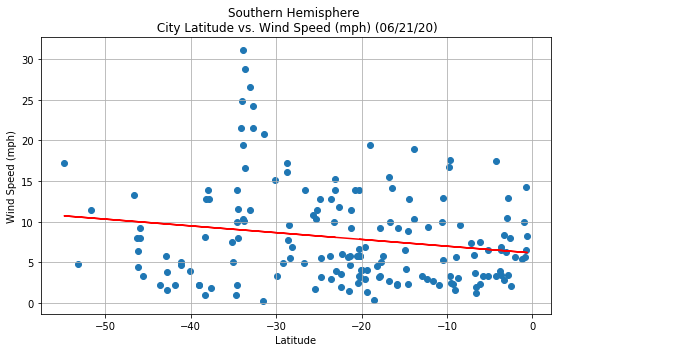

In [27]:
# Southern Hemisphere - Latitude vs. Wind Speed (mph) Linear Regression

x_values = southhem_data["Latitude"]
y_values = southhem_data["Wind Speed"]
xlabel = "Latitude"
ylabel = "Wind Speed (mph)"
title = "Southern Hemisphere \n City Latitude vs. Wind Speed (mph) (06/21/20)"
savefile = "../output_data/Southern Hemisphere - Latitude vs. Wind Speed (mph) Linear Regression.png"

plot(x_values, y_values)